<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
</div>


### Problem Statement
The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks.

I have chosen Ethereum as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict the positive trend over 6 hours only. This will be a binary classification problem with accuracy as the main metric used to measure the effectiveness of the model. The baseline to test the effectiveness fo the model against would be a random guess (i.e. a 50% chance of being correct).

### Data Collection

Using `download.py`, I have downloaded two years worth of hourly ticker data. This script wraps a simple function that pulls data from `yfinance`. The data is saved locally in "ETH-USD_2y_1h.csv" for convenience.

`yfinance` has a restriction on the amount of hourly data that can be downloaded and restricts this to 730 days of data (i.e. 2 years). Given crypto markets never close, this amounts to 17k+ data points. As a general rule of thumb, 5 years of daily data would be required to predict daily returns. On a normal security, this would only be approximately 1,300 data points. Therefore, 2 years of hourly data should be more than sufficient for this problem. In fact, the amount of data may need to be reduced due to harware constraints.

In [22]:
# Imports
# Base
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [23]:
# Collect the data into a dataframe
csv = 'data/ETH-USD_2y_1h.csv'
df = pd.read_csv(csv, index_col='Datetime', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-12-10 11:00:00+00:00,4094.138428,4168.385254,4088.458496,4159.988770,0,0.0,0.0
2021-12-10 12:00:00+00:00,4158.929199,4194.666504,4156.186523,4171.749512,371617792,0.0,0.0
2021-12-10 13:00:00+00:00,4171.667969,4227.111816,4141.002441,4204.396484,1012555776,0.0,0.0
2021-12-10 14:00:00+00:00,4205.823242,4212.586914,4028.301270,4028.301270,0,0.0,0.0
2021-12-10 15:00:00+00:00,4037.234131,4086.067383,3998.373779,4015.867920,717191168,0.0,0.0


### Exploratory Data Analysis


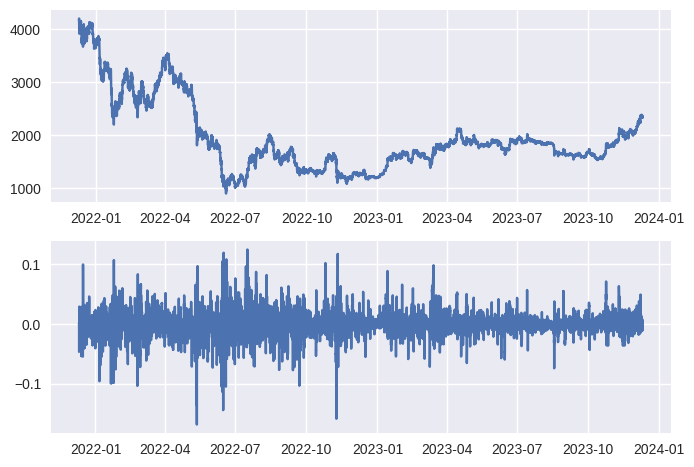

In [30]:
plt.style.use('seaborn-v0_8')
df['6h_return'] = np.log(df['Close']/df['Close'].shift(6))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(df['Close'])
ax2.plot(df['6h_return'])
plt.show()

### Data Cleaning


### Data Transformation


### Deep Learning Model


### Model Validation


### Backtesting

